In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

import xgboost as xgb
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_train_test(df, test_size, condition="backscatter"):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    if(condition=="backscatter"):
        X = df.loc[:,'VH_30':'VH_0']
        # X = df.loc[:,'VH_10':'VH_0']
    elif(condition=="features"):
        X = df.loc[:,'F1':'F17']
    elif(condition=="all"):
        X = df.loc[:,'VH_0':'F17']
    else: 
        print("set the condition")
        return None
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [36]:
from collections import Counter
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 2
    class_2_mask = (y_true == 2)
    if np.any(class_2_mask):  # Check if class 2 is present in the true labels
        return accuracy_score(y_true[class_2_mask], y_pred[class_2_mask])
    else:
        return 0.0  # Return 0 if class 2 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 0, 1, 2, and 3
    class_0123_mask = (y_true >= 0) & (y_true <= 3)
    if np.any(class_0123_mask):  # Check if classes 0, 1, 2, or 3 are present in the true labels
        return accuracy_score(y_true[class_0123_mask], y_pred[class_0123_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

def evaluate_model(X_train, y_train, X_test, y_test, best_params=None, n_splits=5):
    # Convert data to DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    if best_params is None:
        params = {
            "objective": "multi:softprob",  # or "multi:softmax" if you want the class labels directly
            "eval_metric": ['mlogloss'],
            "num_class": len(set(y_train)),  # Number of classes in the target variable
            "max_depth": 8,
            'reg_lambda':2,
            "learning_rate": 0.1,
            "verbosity": 1, 
            "nthread": 8,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
        }
    else:
        print("Best parameters: " + str(best_params))
        params = {
            "objective": "multi:softprob",  # Use softprob to get probabilities for each class
            "eval_metric": ['mlogloss'],  # Evaluation metrics
            "num_class": len(set(y_train)),  # Number of classes
            "nthread": 8,
            **best_params  # Unpack the best parameters from Optuna
        }

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        model = xgb.train(params, dtrain_fold, num_boost_round=1000)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    # Final model evaluation on the test set
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[0, 0:2]) + sum(cm[0, 4:5]) + sum(cm[1, 0:3]) + sum(cm[2, 1:4]) + sum(cm[3, 2:5]) + sum(cm[4, 3:5]) + sum(cm[4, 0:1])) / sum(sum(cm[0:5, 0:5]))

    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

/tmp/ipykernel_1079996/613697827.py:4: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))


<Axes: xlabel='observation', ylabel='count'>

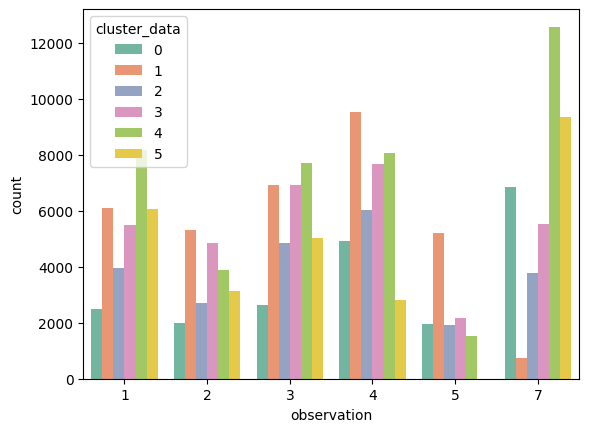

In [37]:
## Read VH dataset
kdprov='32'
df=pd.read_pickle('/data/ksa/04_Data_Preprocessing/32/03_som_filtering/data_with_prior_posterior.pkl').query('prior>=0.5')
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))

In [38]:
import geopandas as gpd
data_cluster=gpd.read_file(f'/data/ksa/00_Data_Input/cluster_data/cluster_{kdprov}_ok.gpkg')

CLUSTER:  0


/tmp/ipykernel_1079996/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 5 1 2 4 3]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       747
           1       0.76      0.64      0.69       598
           2       0.74      0.73      0.73       793
           3       0.78      0.73      0.75      1480
           4       0.83      0.62      0.71       590
           5       0.71      0.86      0.78      2055

    accuracy                           0.76      6263
   macro avg       0.78      0.72      0.74      6263
weighted avg       0.76      0.76      0.76      6263



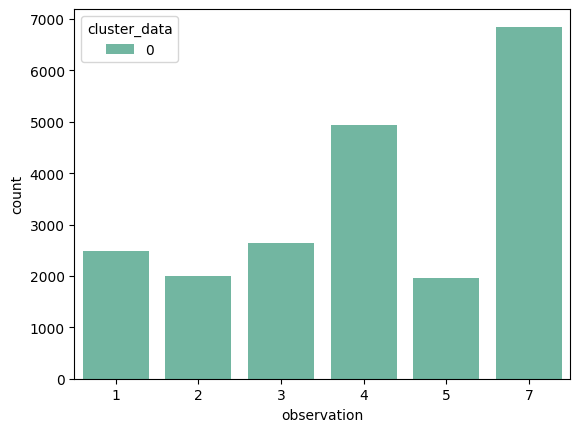

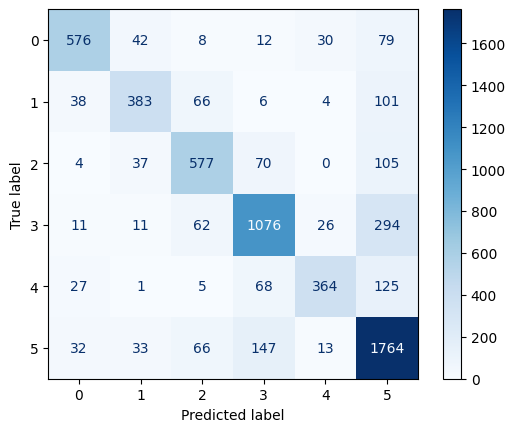

{'average_accuracy': 0.756895147948614, 'average_f1_macro': np.float64(0.7463490481861472), 'average_f1_micro': np.float64(0.756895147948614), 'average_auc': np.float64(0.9393128803844881), 'average_acc_kelas_generatif': 0.7183783783783783, 'average_acc_fase_padi': 0.7244937590776414}
{'val_accuracy': 0.7568258023311512, 'val_f1_macro': np.float64(0.744892345194343), 'val_f1_micro': np.float64(0.7568258023311512), 'val_auc': np.float64(0.9376904097327152), 'val_acc_kelas_generatif': 0.7276166456494325, 'val_acc_fase_padi': 0.7219458264234384, 'val_relative_acc': np.float64(98.23059360730593)}
CLUSTER:  1


/tmp/ipykernel_1079996/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[1 2 3 5 7 4]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1834
           1       0.83      0.88      0.86      1591
           2       0.87      0.85      0.86      2077
           3       0.89      0.91      0.90      2861
           4       0.87      0.86      0.87      1565
           5       0.61      0.27      0.38       225

    accuracy                           0.87     10153
   macro avg       0.83      0.78      0.79     10153
weighted avg       0.87      0.87      0.87     10153



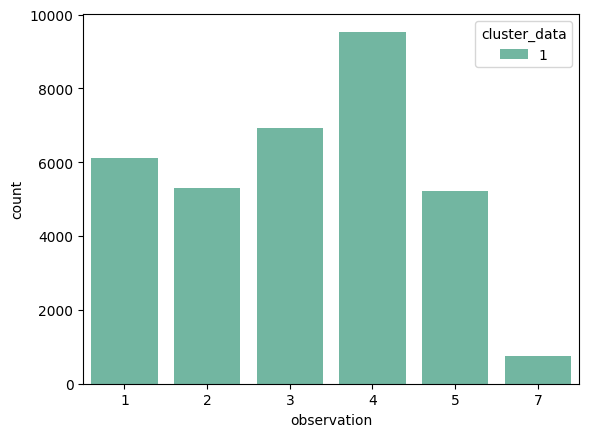

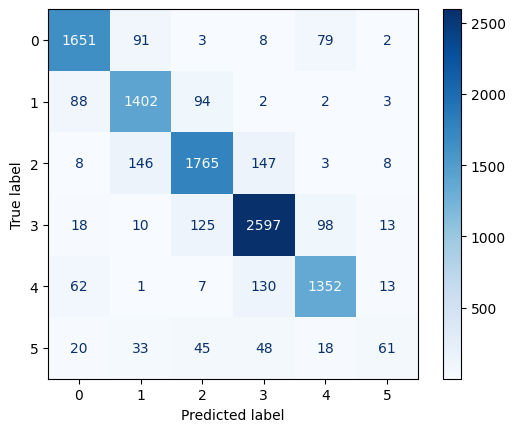

{'average_accuracy': 0.866768048306743, 'average_f1_macro': np.float64(0.7967155186811732), 'average_f1_micro': np.float64(0.866768048306743), 'average_auc': np.float64(0.979927189887803), 'average_acc_kelas_generatif': 0.8551702786377708, 'average_acc_fase_padi': 0.8819763162377032}
{'val_accuracy': 0.869496700482616, 'val_f1_macro': np.float64(0.79176618189145), 'val_f1_micro': np.float64(0.869496700482616), 'val_auc': np.float64(0.9781277107666306), 'val_acc_kelas_generatif': 0.8497833413577275, 'val_acc_fase_padi': 0.8866435489656822, 'val_relative_acc': np.float64(99.3730407523511)}
CLUSTER:  2
[2 5 4 7 3 1]


/tmp/ipykernel_1079996/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1183
           1       0.71      0.75      0.73       814
           2       0.82      0.81      0.81      1457
           3       0.74      0.77      0.76      1810
           4       0.68      0.57      0.62       576
           5       0.64      0.66      0.65      1136

    accuracy                           0.74      6976
   macro avg       0.73      0.72      0.72      6976
weighted avg       0.74      0.74      0.74      6976



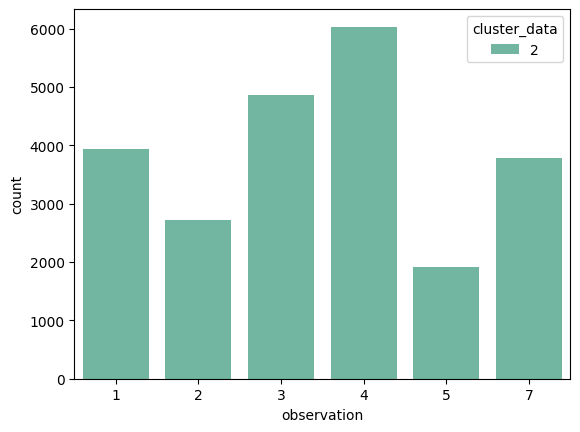

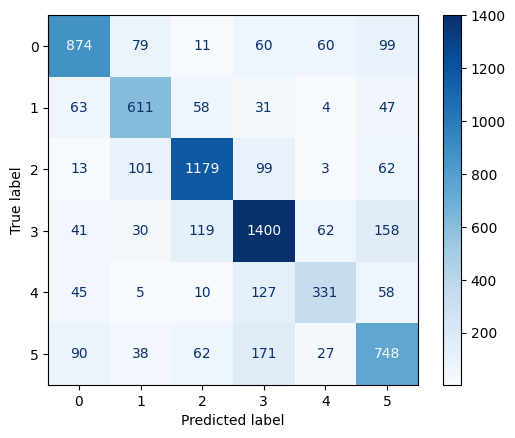

{'average_accuracy': 0.7267138818751723, 'average_f1_macro': np.float64(0.7096377525061752), 'average_f1_micro': np.float64(0.7267138818751723), 'average_auc': np.float64(0.9378453227145869), 'average_acc_kelas_generatif': 0.8023529411764706, 'average_acc_fase_padi': 0.7666687546980706}
{'val_accuracy': 0.7372419724770642, 'val_f1_macro': np.float64(0.7212706912982179), 'val_f1_micro': np.float64(0.7372419724770642), 'val_auc': np.float64(0.9402887783831947), 'val_acc_kelas_generatif': 0.8091969800960879, 'val_acc_fase_padi': 0.7720364741641338, 'val_relative_acc': np.float64(96.15952732644018)}
CLUSTER:  3


/tmp/ipykernel_1079996/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[7 2 4 3 1 5]
[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      1647
           1       0.70      0.73      0.71      1452
           2       0.73      0.76      0.74      2073
           3       0.69      0.73      0.71      2296
           4       0.71      0.41      0.52       655
           5       0.56      0.58      0.57      1663

    accuracy                           0.68      9786
   macro avg       0.69      0.65      0.66      9786
weighted avg       0.68      0.68      0.68      9786



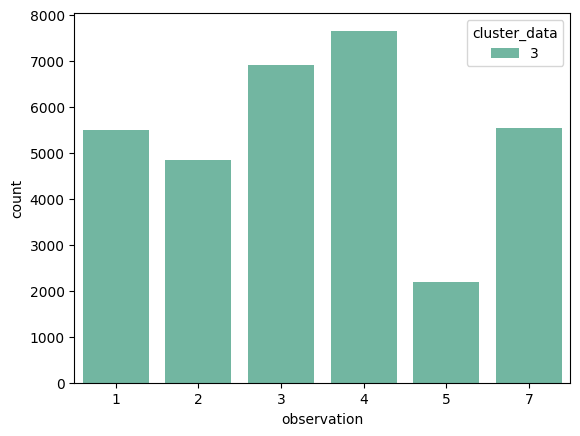

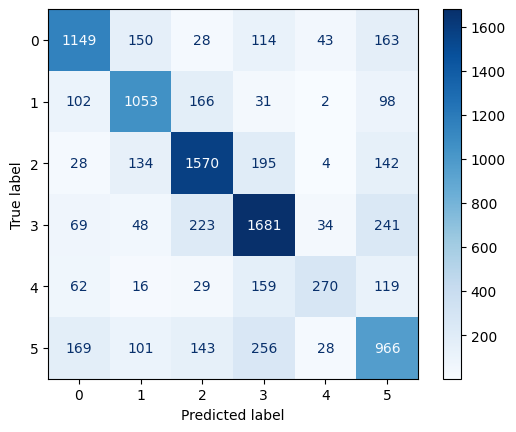

{'average_accuracy': 0.6814999164145918, 'average_f1_macro': np.float64(0.6620599590619626), 'average_f1_micro': np.float64(0.6814999164145918), 'average_auc': np.float64(0.9119990875449459), 'average_acc_kelas_generatif': 0.7554216841727418, 'average_acc_fase_padi': 0.7210329985652797}
{'val_accuracy': 0.6835274882485183, 'val_f1_macro': np.float64(0.6614212783740583), 'val_f1_micro': np.float64(0.6835274882485183), 'val_auc': np.float64(0.9150529254826026), 'val_acc_kelas_generatif': 0.7573564881813797, 'val_acc_fase_padi': 0.7301821103374397, 'val_relative_acc': np.float64(94.98641304347827)}
CLUSTER:  4
[3 2 7 4 5 1]


/tmp/ipykernel_1079996/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4 5]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(5): np.int64(4), np.int64(7): np.int64(5)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2449
           1       0.75      0.70      0.72      1162
           2       0.79      0.75      0.77      2309
           3       0.73      0.71      0.72      2422
           4       0.72      0.38      0.50       456
           5       0.70      0.83      0.76      3771

    accuracy                           0.75     12569
   macro avg       0.76      0.69      0.71     12569
weighted avg       0.76      0.75      0.75     12569



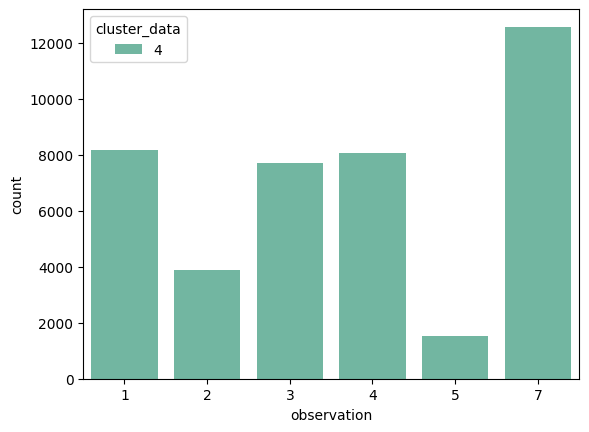

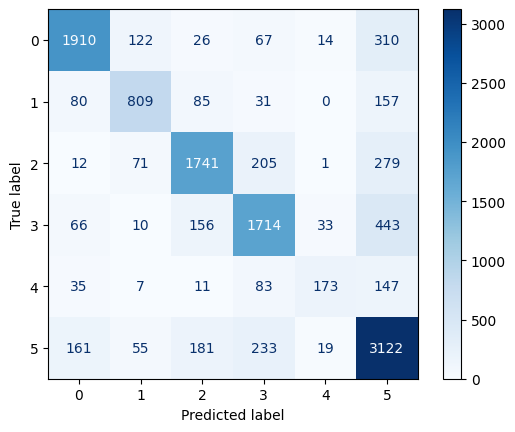

{'average_accuracy': 0.7513894365466431, 'average_f1_macro': np.float64(0.7141440814044601), 'average_f1_micro': np.float64(0.7513894365466431), 'average_auc': np.float64(0.9361940290458657), 'average_acc_kelas_generatif': 0.7626210372728478, 'average_acc_fase_padi': 0.739737634324965}
{'val_accuracy': 0.7533614448245683, 'val_f1_macro': np.float64(0.7138671153952351), 'val_f1_micro': np.float64(0.7533614448245683), 'val_auc': np.float64(0.9375138038418115), 'val_acc_kelas_generatif': 0.7540060632308359, 'val_acc_fase_padi': 0.7401102853032846, 'val_relative_acc': np.float64(96.90431519699813)}
CLUSTER:  5
[7 1 2 4 3]


/tmp/ipykernel_1079996/3786763478.py:9: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))


[0 1 2 3 4]
Mapping of original to encoded classes: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(3): np.int64(2), np.int64(4): np.int64(3), np.int64(7): np.int64(4)}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1814
           1       0.89      0.90      0.90       939
           2       0.93      0.94      0.94      1513
           3       0.93      0.89      0.91       842
           4       0.92      0.94      0.93      2800

    accuracy                           0.93      7908
   macro avg       0.93      0.92      0.92      7908
weighted avg       0.93      0.93      0.93      7908



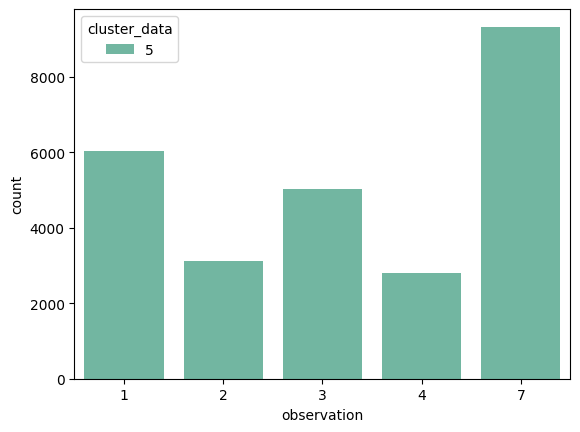

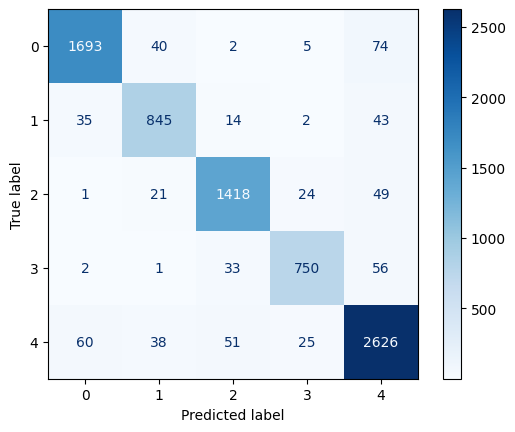

{'average_accuracy': 0.9284086905892088, 'average_f1_macro': np.float64(0.9228052834179055), 'average_f1_micro': np.float64(0.9284086905892088), 'average_auc': np.float64(0.9912972509940593), 'average_acc_kelas_generatif': 0.9376770538243626, 'average_acc_fase_padi': 0.9236447628194115}
{'val_accuracy': 0.9271623672230652, 'val_f1_macro': np.float64(0.9224048596955058), 'val_f1_micro': np.float64(0.9271623672230652), 'val_auc': np.float64(0.9913052137869658), 'val_acc_kelas_generatif': 0.9372108393919365, 'val_acc_fase_padi': 0.9212999216914644, 'val_relative_acc': np.float64(97.54678806272129)}


In [39]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
df=df.query('observation!=6')
dict_report={}
for i in [0,1,2,3,4,5]:
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.3, condition="backscatter")
    
    X_train_n=X_train.copy()
    cols=X_train.columns
    for index, rows in X_train.iterrows():
        mean=np.mean(rows)
        std=np.std(rows)
        for x in cols:
            X_train_n.at[index,x]=(rows[x]-mean)/std
    
    X_test_n=X_test.copy()
    for index, rows in X_test.iterrows():
        mean=np.mean(rows)
        std=np.std(rows)
        for x in cols:
            X_test_n.at[index,x]=(rows[x]-mean)/std
    
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Train and evaluate the model using the standardized features
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train_n, y_train_encoded, X_test_n, y_test_encoded)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)

In [41]:
import pickle
with open('/data/ksa/00_Code/07_Modeling/model/xgboost.pkl','wb') as file:
    pickle.dump(dict_report,file)